<a href="https://colab.research.google.com/github/GB-studyingcode/Region-Clustering-Project/blob/main/Region_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Library

# For data processing
import numpy as np
import pandas as pd

# For accessing spreadsheet on Google Drive
from google.colab import auth
import gspread
from google.auth import default
from google.colab import drive

# For machine learning clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# For optimization
!pip install gurobipy
import gurobipy as gp
from gurobipy import *

# For using squareroot
import math

# For map visualization
import folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 86.1 MB/s eta 0:00:00


In [ ]:
# Authenticate with Google Drive
#auth.authenticate_user()
#creds,_ = default()
#gc = gspread.authorize(creds)

# Task 1 : Clustering the cities based on latitude and longtitude

In [ ]:
# Access spreadsheets
path = "/content/drive/MyDrive/e11.xlsx"  # chỉnh đúng đường dẫn
df = pd.read_excel(path, sheet_name="Final", engine="openpyxl")
display(df)

,City,Lat_cleaned,Long_cleaned
0,An Giang,10.521583,105.125895
1,Thừa Thiên Huế,16.467397,107.590532
2,Kiên Giang,9.824959,105.125895
3,Hải Phòng,20.844911,106.688084
4,Bình Định,13.886021,109.107738
...,...,...,...
58,Thái Bình,20.446347,106.336582
59,Ninh Bình,20.250614,105.974453
60,Nam Định,20.438822,106.162105
61,Yên Bái,21.716768,104.898587


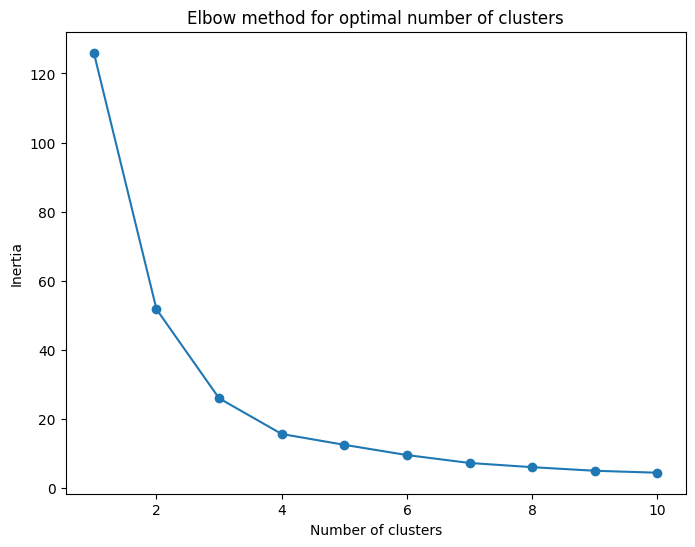

In [ ]:
# Clustering based on latitude and longitude
clustering_data = df[['Lat_cleaned','Long_cleaned']]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Use the elbow method to optimization number of clusters
inertia = []
for i in range(1,11):
  kmeans = KMeans(n_clusters= i,random_state=0,n_init=20)   # n_init là số lần chạy random
  kmeans.fit(scaled_data)
  inertia.append(kmeans.inertia_)   # inertia_ là kết quả đã học

# Plot elbow method
plt.figure(figsize=(8,6))
plt.title('Elbow method for optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot(range(1,11),inertia,marker='o')
plt.show()

In [ ]:
# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0, n_init = 20)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Create a map centrered around the average latitude and longitude
map_center = [df['Lat_cleaned'].mean(),df['Long_cleaned'].mean()]
map = folium.Map(location = map_center , zoom_start=6)

# Define colors for each cluster
cluster_colors = ['red', 'blue', 'green']

# Add markers for each city, colored by cluster
for index,row in df.iterrows():
  folium.Marker(
      location = [row['Lat_cleaned'],row['Long_cleaned']],
      popup = f"{row['City']} - Cluster {row['Cluster']}",
      icon = folium.Icon(color=cluster_colors[row['Cluster']])
  ).add_to(map)

# Display the map
map

# Task 2: Defining warehouse location

In [ ]:
path = "/content/drive/MyDrive/e11.xlsx"  # chỉnh đúng đường dẫn
df = pd.read_excel(path, sheet_name="MienTay", engine="openpyxl")
display(df)

,City,Lat_cleaned,Long_cleaned
0,An Giang,10.521583,105.125895
1,Kiên Giang,9.824959,105.125895
2,Bến Tre,10.243355,106.375551
3,Bạc Liêu,9.294003,105.721566
4,Long An,10.560716,106.649762
5,Vĩnh Long,10.239574,105.957192
6,Tiền Giang,10.449332,106.342050
7,Cà Mau,9.152673,105.196079
8,Trà Vinh,9.951332,106.334606
9,Đồng Tháp,10.493798,105.688178


In [ ]:
# Creat a model to minimize squared Euclidean distance
model_1 = gp.Model('minimize_squared_euclidean_distance')

# Decision Varible
optimal_lat_1 = model_1.addVar(vtype=GRB.CONTINUOUS, name ='optimal_lat')
optimal_long_1 = model_1.addVar(vtype=GRB.CONTINUOUS, name ='optimal_long')

# Objective function to minimize the sum of Euclidean distance
objective = gp.QuadExpr()
for i in range(len(df)):
  lat_i = df['Lat_cleaned'][i]
  long_i = df['Long_cleaned'][i]
  objective += (optimal_lat_1 - lat_i)**2 + (optimal_long_1 - long_i)**2
model_1.setObjective(objective,GRB.MINIMIZE)

# Optimize the model
model_1.optimize()

# Store optimal coordinates
if model_1.Status == GRB.OPTIMAL:
  print('Optimal Location:')
  print(f'Lattitude: {optimal_lat_1.X}')
  print(f'Longtitude:{optimal_long_1.x}')
  print(f'Minimum total  distance:{model_1.ObjVal}')
else:
  print('No optimal solution found')


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 0 rows, 2 columns and 0 nonzeros
Model fingerprint: 0x1bdebb7d
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+02, 3e+03]
  QObjective range [3e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 2 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective 5.56190755e+00
Optimal Location:
Lattitude: 10.01497190769231
Longtitude:105.83682946153846
Minimum total  distance:5.561907545867143


In [ ]:
# Create model to minimize Euclidean distance
model_2 = gp.Model('minimize Euclidean distance')

# Decision variables: latitude and longitude of the optimal point
optimal_lat_2 = model_2.addVar(vtype = GRB.CONTINUOUS, name ='optimal_lat')
optimal_long_2 = model_2.addVar(vtype = GRB.CONTINUOUS, name ='optimal_long')
s_i = model_2.addVars(len(df),vtype = GRB.CONTINUOUS, name =f'distance_{i}')

# Add variables to represent the Euclidean distance to each point
# We introduce a variable 'd_i' for the distance to each point i, and a variable 's_i'
# where s_i >= sqrt((optimal_lat_gm - lat_i)^2 + (optimal_long_gm - long_i)^2)
# This can be formulated as a Second-Order Cone constraint:
# (s_i)^2 >= (optimal_lat_gm - lat_i)^2 + (optimal_long_gm - long_i)^2
# Which is equivalent to || (optimal_lat_gm - lat_i, optimal_long_gm - long_i) ||_2 <= s_i


# Minimize sum of Euclidean distances
model_2.setObjective(gp.quicksum(s_i[i] for i in range(len(df))),GRB.MINIMIZE)

# Objective function to minimize the sum of Euclidean distance

for i in range(len(df)):
  lat = df['Lat_cleaned'][i]
  long = df['Long_cleaned'][i]
   # Add the Second-Order Cone constraint
    # || (optimal_lat_gm - lat_i, optimal_long_gm - long_i) ||_2 <= d_i
  model_2.addConstr((optimal_lat_2 - lat)**2 +(optimal_long_2 - long)**2 <= s_i[i] * s_i[i], name=f"second-order cone_{i}")




# Optimize the model
model_2.optimize()

# Store optimal coordinates
if model_2.Status == GRB.OPTIMAL:
  print('Optimal Location:')
  print(f'Lattitude: {optimal_lat_2.X}')
  print(f'Longtitude:{optimal_long_2.x}')
  print(f'Minimum total  distance:{model_2.ObjVal}')
else:
  print('No optimal solution found')




Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 0 rows, 15 columns and 0 nonzeros
Model fingerprint: 0x1af7aef3
Model has 13 quadratic constraints
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+01, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [1e+04, 1e+04]
Presolve time: 0.01s
Presolved: 26 rows, 41 columns, 52 nonzeros
Presolved model has 13 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.690e+02
 Factor NZ  : 3.110e+02
 Factor Ops : 4.601e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal

In [ ]:
# Create a map centered around the average latitude and longitude for each province in "Miền Tây"
map_center_mien_tay = [df['Lat_cleaned'].mean(),df['Long_cleaned'].mean()]
map_mien_tay = folium.Map(location = map_center_mien_tay , zoom_start= 7)

# Add markers for each city
for index,row in df.iterrows():
  folium.Marker(
      location = [row['Lat_cleaned'],row['Long_cleaned']],
      popup = row['City'],
      icon = folium.Icon(color='green')
  ).add_to(map_mien_tay)

# Add optimal point to the map
folium.Marker(location= [optimal_lat_2.x,optimal_long_2.x] ,popup ='Optimal Point', icon =folium.Icon(color ='red',icon='star')).add_to(map_mien_tay)

# Display the map
map_mien_tay

#Task 3: Design milk-run path starting from the defined warehouse location to all cities

In [ ]:
#  Choose optimal point 2 to be the starting point and add it to the dataframe
add_column = {'City':['Starting Point'],'Lat_cleaned':[optimal_lat_2.x],'Long_cleaned':[optimal_long_2.x]}
df = pd.concat([df,pd.DataFrame(add_column)],ignore_index= True)
df


,City,Lat_cleaned,Long_cleaned
0,An Giang,10.521583,105.125895
1,Kiên Giang,9.824959,105.125895
2,Bến Tre,10.243355,106.375551
3,Bạc Liêu,9.294003,105.721566
4,Long An,10.560716,106.649762
5,Vĩnh Long,10.239574,105.957192
6,Tiền Giang,10.449332,106.342050
7,Cà Mau,9.152673,105.196079
8,Trà Vinh,9.951332,106.334606
9,Đồng Tháp,10.493798,105.688178


In [ ]:
# Distance Matrix
def euclidean_matrix(lat_1,long_1,lat_2,long_2):
  return math.sqrt((lat_1 - lat_2)**2+(long_1 - long_2)**2)

distance_matrix = np.zeros((len(df),len(df)))    #.zeros(shape, dtype=float, order='C', *, like=None)->Return a new array of given shape and type, filled with zeros.
for i in range(len(df)):
  for j in range(len(df)):
    lat_1 = df['Lat_cleaned'][i]
    long_1 = df['Long_cleaned'][i]
    lat_2 = df['Lat_cleaned'][j]
    long_2 = df['Long_cleaned'][j]
    distance_matrix[i,j] = euclidean_matrix(lat_1,long_1,lat_2,long_2)

print('Distance Matrix:')
print(distance_matrix)

Distance Matrix:
[[0.         0.6966243  1.28025425 1.36446962 1.52436939 0.87782901
  1.2182993  1.37070819 1.33647632 0.56296907 0.92130764 1.20872254
  0.78266644 0.85955737]
 [0.6966243  0.         1.31783746 0.79795878 1.69219072 0.9289567
  1.36706803 0.67593944 1.2152993  0.87378955 0.51970183 0.8638562
  0.65884588 0.74009001]
 [1.28025425 1.31783746 0.         1.15280795 0.41941588 0.41837609
  0.20868359 1.60646875 0.29487991 0.73157593 0.88026338 0.70804612
  0.65919803 0.5787086 ]
 [1.36446962 0.79795878 1.15280795 0.         1.57038543 0.97448689
  1.31140619 0.54416057 0.8988322  1.20025977 0.47079624 0.44476183
  0.75158381 0.75075622]
 [1.52436939 1.69219072 0.41941588 1.57038543 0.         0.76340382
  0.32725078 2.02380333 0.68605587 0.96390965 1.28903426 1.12588599
  1.03973151 0.96885778]
 [0.87782901 0.9289567  0.41837609 0.97448689 0.76340382 0.
  0.43830822 1.32689382 0.47489473 0.37013291 0.57604683 0.5795629
  0.28642435 0.237224  ]
 [1.2182993  1.36706803 0.20

Reasoning: Set up the TSP model using Gurobi, defining variables and constraints as described in the instructions

In [ ]:
# Create optimization for TSP model
model_3 = gp.Model('TSP')

# Number of cities (including the startign point)
n = len(df)

# Decision variables: x[i, j] is 1 if we travel from city i to city j, 0 otherwise
x = model_3.addVars(n,n,vtype = GRB.BINARY, name ='x')

# Continuous variables for subtour elimination (Miller-Tucker-Zemlin formulation)
# u[i] represents the position of city i in the tour. We can exclude the start city (index n-1).
u = model_3.addVars(n,vtype = GRB.CONTINUOUS, name ='u')

# Objective function : minimize the distance travel
model_3.setObjective(gp.quicksum(distance_matrix[i,j] * x[i,j] for i in range(n) for j in range(n)),GRB.MINIMIZE)

# Constraints:
# 1. Each city must be entered exactly once
for j in range(n):
  model_3.addConstr(gp.quicksum(x[i,j] for i in range(n) if i!=j)==1, name = f'enter_{i}')

# 2. Each city must be exited exactly once
for i in range(n):
  model_3.addConstr(gp.quicksum(x[i,j] for j in range(n) if j!=i)==1, name=f'exit_{i}')

# 3. Subtour elimination constraints (Miller-Tucker-Zemlin)
# Exclude the starting city (index n-1) from these constraints
for i in range(n):
  for j in range(n):
    if i!=j and i!=n-1 and j!=n-1:
      model_3.addConstr(u[i]-u[j]+n*x[i,j]<= n-1, name = f'subtour_{i}_{j}')

# Constraints for the starting city's position variable (can be set to 0 or 1)
# We can set the position of the starting city (index n-1) to 0.
model_3.addConstr(u[n-1]==0, name = 'start_pos')

# Constraints on the range of u variables for non-start cities
for i in range(n-1):
  model_3.addConstr(u[i]>=1 , name=f"u_lower_{i}")
  model_3.addConstr(u[i]<= n-1, name = f"u_upper_{i}")


# Optimize the model
model_3.optimize()

# Check the optimization status
if model_3.status == GRB.OPTIMAL:
    print("Optimal solution found for the TSP.")
elif model_3.status == GRB.INF_OR_UNBD:
    print("Model is infeasible or unbounded.")
elif model_3.status == GRB.INFEASIBLE:
    print("Model is infeasible.")
elif model_3.status == GRB.UNBOUNDED:
    print("Model is unbounded.")
else:
    print(f"Optimization did not finish with status {model_3.status}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 211 rows, 210 columns and 859 nonzeros
Model fingerprint: 0xeb7559ba
Variable types: 14 continuous, 196 integer (196 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 27 rows and 15 columns
Presolve time: 0.01s
Presolved: 184 rows, 195 columns, 1668 nonzeros
Variable types: 13 continuous, 182 integer (182 binary)
Found heuristic solution: objective 11.2385152

Root relaxation: objective 5.398941e+00, 59 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

In [ ]:

# Extract the optimal tour
if model_3.status == GRB.OPTIMAL:
  optimal_tour = []
  start_node = n - 1 # Start from the optimal start point
  current_node = start_node

  while True:
      optimal_tour.append(df['City'][current_node])
      next_node = -1
      for j in range(n):
          # Check if the variable x[current_node, j] is in the model and its value is close to 1
          if x[current_node, j].X > 0.5 and j!= current_node:
              next_node = j
              break  # Assuming there's only one outgoing edge from each node in a valid tour

      current_node = next_node
      if current_node == start_node or next_node == -1:
              break

  # Print the optimal tour
  print("Optimal Tour:")
  print(' -> '.join(optimal_tour))

  # Print the optimal objective value (total distance)
  print(f"Optimal Total Distance: {model_3.ObjVal}")

else:
    print("No optimal tour found.")

Optimal Tour:
Starting Point -> Cần Thơ -> Đồng Tháp -> An Giang -> Kiên Giang -> Cà Mau -> Bạc Liêu -> Hậu Giang -> Sóc Trăng -> Trà Vinh -> Bến Tre -> Long An -> Tiền Giang -> Vĩnh Long
Optimal Total Distance: 6.019049979966727


In [ ]:
# Create a list of coordinates in the order of the optimal tour
tour_coordinate = []
for city_name in optimal_tour:
      city_row = df[df['City'] == city_name]
      if not city_row.empty:
          tour_coordinate.append((city_row['Lat_cleaned'].iloc[0],city_row['Long_cleaned'].iloc[0]))

# Add a PolyLine layer for the optimal tour
folium.PolyLine(locations = tour_coordinate,
                color = 'red',
                weight = 2.5,
                opacity = 1
                ).add_to(map_mien_tay)

# Display the map
map_mien_tay
